<a href="https://colab.research.google.com/github/winwinteam/1sutd-stats-team5-prj/blob/main/Team_5_Project_(JH)_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naming convention (To delete)


*   dfjh : JH's df
*   dftz : Terry's df
* dfsc
* dfjw
* dfvc 

# History (to delete during presentaiton)
[May 10] Vincent: draft based on JH's v1.0

[May 12] Vincent: update utility section to for datetime

[May 17] JH 7pm updated intro and JH's section 




# Common code

In [ ]:
IS_RUNNING_GOOGLE_COLAB = True
#IS_RUNNING_GOOGLE_COLAB = False

csv_pathname = "../dataset/" + "Ecommerce - Hour Data.csv"
sum_pathname = "../dataset/" + "Ecommerce - Hour Data-sum-day.csv"

if IS_RUNNING_GOOGLE_COLAB:  
  zip_pathname = "../dataset/" +  "Ecommerce - Hour Data.zip"


In [ ]:
# import libarry
import os
import time
import pytz

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt


import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import skew, kurtosis
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency

import seaborn as sns

from statsmodels.stats.diagnostic import normal_ad
import statsmodels.api as sm

from sklearn.preprocessing import QuantileTransformer


In [ ]:
# timing information for checking errors
dt.timezone(offset=dt.timedelta(hours=+8))
print("-"*20)
starttime = dt.datetime.now(pytz.timezone('Singapore'))
print(f"START time {str(starttime).split('.')[0]}")
print(f"\tcheck END time at the final cell output \n\tto confirm the notebook is successfully executed till the end")

--------------------
START time 2022-05-17 20:00:53
	check END time at the final cell output 
	to confirm the notebook is successfully executed till the end


 Project Requirement (to[link text](https:// [link text](https://)) delete during 

> [Indented block](https:// [link text](https:// [link text](https:// [link text](https://))))








```
# This is formatted as code
```

tepresentation)
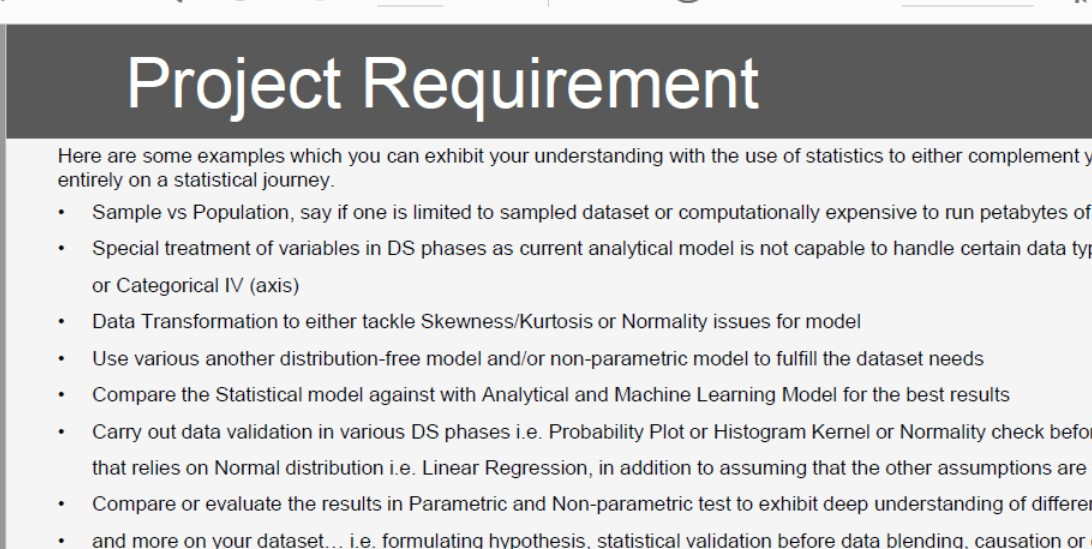

## Introduction

We investigated 3 business objectives and presented their respective conclusion and supporting statistical test result.

|Business objective|Finding|Supporting test result|
|-|-|-|
|-|-|-|
|-|-|-|
|-|-|-|
|-|-|-|

# Team 5 - Data Validation and Statistical Analysis Project

## Team members
1. Terry Choo
2. Tay Soon Chee
3. Vincent Chong
4. John Moo
5. Jhohan Kamardi

# Background

Our company - XYZ has engaged external vendor to perform analysis on our e-commerce data, with the objective of providing business analytic services to our members (sellers and buyers) and eventually provide an improved online shopping experience to all of them.

We are from XYZ's Data Science department. We are tasked by our management to perform Data Validation and Statistical Analysis to support the observations / analytics' reports produced by the external vendor.

## Business Objectives
To increase conversion and to provide a robust e-commerce platform through the understanding of buyers' online shopping behaviour and through transactions made in the platform, which cover some of the following:
* Trend spotting based on timestamp, customers, product names, product types, sales amount, ordered and returned quantity
* Top product categories revenue contributors
* Top profit contributors
* Correlation between ordered item quantity and returned item quantity

## Applied Tests
* Normality Test: D'Agostino-Pearson, Shapiro-Wilk, K^2 Normality
* Probability Plot: Quantile-Quantile (Q-Q) Plot, Histogram KDE 
* Transform feature: Yeo Johnson, Log
* Non Parametric Testing: Spearman, Wilcoxon
* ...

# Data 

<b>Name:</b> Hourly E-Commerce Data

<b>Size:</b> ? mb, ? rows, ? columns

<b>Period:</b> 

Dataset source: 

## Common Utility functions

Here are the reusable utitlity functions


In [ ]:
# mout google drive
import time
if IS_RUNNING_GOOGLE_COLAB:
  from google.colab import drive
  import zipfile
  drive.mount('/content/drive')
  project_dir = "/content/drive/.shortcut-targets-by-id/1hq1js1i_5vtP8Ib96QdKM31o5JrADOez/sutd-team5-prj/" #don't change    
  src_dir = project_dir + "src/"
  os.chdir(src_dir)
  assert os.path.exists(zip_pathname), print(f"can't find {zip_pathname} in Google drive")    

print(f"current working directory is \n\t{os.getcwd()}")



Mounted at /content/drive
current working directory is 
	/content/drive/.shortcut-targets-by-id/1hq1js1i_5vtP8Ib96QdKM31o5JrADOez/sutd-team5-prj/src


In [ ]:
def get_df_from_protected_zipfile(zip_pathname, password='VNjAMFv268"(*C*y'):

  assert(os.path.exists(zip_pathname)), print(f"can't find {zip_pathname}")

  # file = zipfile.ZipFile(zip_pathname)
  # file.setpassword(pwd = bytes('VNjAMFv268"(*C*y', 'utf-8' ))  

  with zipfile.ZipFile(zip_pathname) as file:
    try: 
      file.extractall(pwd=bytes(password, 'utf-8' ), path=os.path.dirname(zip_pathname))
    except:    
      assert False, print(f"fail to unzip {zip_pathname}")

  csv_pathname = zip_pathname[:-4]+'.csv'  
  assert os.path.exists(csv_pathname), print(f"can't find {csv_pathname}")
  try:
    df =pd.read_csv(csv_pathname)  
    print(f"read {csv_pathname}")
  except:
    print(f"can't read {csv_pathname}")

  os.remove(csv_pathname)
  print(f"removed {csv_pathname}")      

  return df

In [ ]:
assert(os.path.exists(zip_pathname)), print(f"can't find {zip_pathname}")
file = zipfile.ZipFile(zip_pathname)
file.setpassword(pwd = bytes('VNjAMFv268"(*C*y', 'utf-8' ))
print(file.infolist)
# file.setpassword(pwd = bytes(password, 'utf-8' ))  
print(f"unzipping {zip_pathname}")
file.extractall()

os.listdir("../dataset/")

<bound method ZipFile.infolist of <zipfile.ZipFile filename='../dataset/Ecommerce - Hour Data.zip' mode='r'>>
unzipping ../dataset/Ecommerce - Hour Data.zip


['cookie_cats.csv',
 'WhatsgoodlyData-10.csv',
 'WhatsgoodlyData-6.csv',
 'csv-list.txt',
 'Ecommerce - Hour Data.zip']

In [ ]:
# utility functions
# Hypothesis test on non-probability based sampling

def get_df_sum_by_date(df:pd.DataFrame,
                         column_date:str, 
                         column_aggregate=[], 
                         freq='D',
                         is_plot=True
                         ):
    """_summary_
    Aggregate columns in input dataframe by summing values given in "column_aggregate",
    according to frequency given for column_date
    
    :param df: _description_
    :type df: pd.DataFrame
    :param column_date: name of the column that stores date
    :type column_date: str
    :param column_aggregate: _description_, defaults to []
    :type column_aggregate: list, list of column name for the column to be stored
    :param freq: _description_, defaults to 'D'
    :type freq: str, default sum by day
    :param is_plot: _description_, defaults to True
    :type is_plot: bool, optional
    :return: _description_
    :rtype: _type_
    """
    
    df[f"{column_date}"] = pd.to_datetime(df[f"{column_date}"])    
    # df.rename(columns={column_date:"yyyy-mm-dd"})
    df.set_index(column_date, inplace=True)
    df_sum = df[column_aggregate].resample(rule=freq).sum()    
    
    if(is_plot):
        df_sum.plot(subplots=True, grid=True, figsize=(10, len(column_aggregate)))
        plt.show() 
    
    df_sum.reset_index(inplace=True)
    
    return df_sum

def plot_qqplot(df_series, title, ax):
    fontsize = 14
    sm.qqplot(df_series, line="s", ax=ax)
    ax.set_title(f"{title}")
    # ax.set_ylabel(fontdict={'fontsize':fontsize})
    plt.show()

def plot_hist_kde_qq(df_series, is_input_transformed=False):
    df_series_name = argname("df_series")
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.subplots_adjust(wspace=0.3)
    fig.set_figwidth(14)
    print(f"{df_series_name}.mean()", round(df_series.mean()))
    if is_input_transformed == False:
        print(f"np.log({df_series_name}.mean())", round(np.log(df_series.mean()), 2))
        print(f"np.log({df_series_name}.std())", round(np.log(df_series.std()), 2))
    df_series.plot.hist(title=df_series_name, ax=ax1)
    df_series.plot.kde(title=df_series_name, ax=ax1, secondary_y=True)

    plot_qqplot(df_series, df_series_name, ax=ax2)
    plt.show()


def plot_pivot(index, columns, normalize="index", figsize=(20, 20),
               ncol=1, bbox_to_anchor=(1.35, 0.3), loc='center right'):

    df_crosstab_normalized = pd.crosstab(
        index=index, columns=columns, normalize=normalize
    )
    # display(df_crosstab_normalized)
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    fig.add_subplot(ax)
    df_crosstab_normalized.plot(kind="bar", stacked=True, ax=ax)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.4, box.height * 0.5])

    # Put a legend to the right of the current axis
    ax.legend(loc=loc, bbox_to_anchor=bbox_to_anchor, ncol=ncol)
    plt.show()

# JH's section

## Background

### This section focuses on the analysis and hypothesis testing on ordered and returned item quantity which are grouped by product type (category)

Data is a 7-month sample data which include all product types and its transactions. Various hypothesis are tested to draw some conclusions where a simple data pre-processing is done (only focused on 3 columns) 

## Business Motivation behind Hypothesis Testing

Decision making is a crucial part of every business. E-Commerce manager is planning to create a program which incentivize Sellers whom have successfully reduce return orders due to various reasons (false product info, product defects etc.). E-Commerce manager currently believes product type with top transaction counts are having the most return orders but he is not sure the has enough evidence to support his assumption / hypothesis.

## Data Pre-processing

* product_type, ordered_item_quantity, returned_item_quantity

The dataset is an ecommerce

> Indented block



In [ ]:
if IS_RUNNING_GOOGLE_COLAB: 
    assert os.path.exists(zip_pathname), print(f"can't find {zip_pathname}")
    dfjh = get_df_from_protected_zipfile(zip_pathname = zip_pathname)
else:
    dfjh = pd.read_csv(csv_pathname)

read ../dataset/Ecommerce - Hour Data.csv
removed ../dataset/Ecommerce - Hour Data.csv


In [ ]:
# New DataFrame only for 3 focused columns
dfjh = pd.DataFrame(dfjh[["product_type", "ordered_item_quantity", "returned_item_quantity"]])
print('Current DataFrame')
print('=================')
display(dfjh)

# Convert negative returned quantity to positive number
dfjh["returned_item_quantity"] = dfjh["returned_item_quantity"] * -1

# Remove rows with zero ordered and returned quantity
index_null = dfjh.loc[(dfjh.ordered_item_quantity==0) & (dfjh.returned_item_quantity==0)].index
print('')
print('Index with zero ordered and returned quantity (to be removed)')
print('=============================================================')
print(index_null)
dfjh = dfjh.drop(index_null)

print('')
print('DataFrame info after the removal of zero ordered and returned quantity')
print('======================================================================')

print(dfjh.info())

display(dfjh)
print('='*120)

# Remove row - null product type
dfjh = dfjh.dropna(subset = ['product_type'])


# Get statistic of sample data - product_type (count, mean, variance, standard deviation). Round to the nearest whole number.
print('')
print('Latest DataFrame Statistic Information')
print('======================================')
print(dfjh.describe())
print('='*120)

pop_count = round(dfjh.product_type.count(),5)

print ("Sample Count for Product Type = ", pop_count)
print ("Unique count for Product Type = ", len(dfjh["product_type"].unique()))
print('='*120)

Current DataFrame


,product_type,ordered_item_quantity,returned_item_quantity
0,NaN,0,0
1,NaN,0,0
2,NaN,0,0
3,NaN,0,0
4,NaN,0,0
...,...,...,...
6977,NaN,0,0
6978,NaN,0,0
6979,Blush,1,0
6980,NaN,0,0



Index with zero ordered and returned quantity (to be removed)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            6971, 6972, 6973, 6974, 6975, 6976, 6977, 6978, 6980, 6981],
           dtype='int64', length=4897)

DataFrame info after the removal of zero ordered and returned quantity
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2085 entries, 17 to 6979
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   product_type            2084 non-null   object
 1   ordered_item_quantity   2085 non-null   int64 
 2   returned_item_quantity  2085 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 65.2+ KB
None


,product_type,ordered_item_quantity,returned_item_quantity
17,Face Moisturizer,1,0
18,Daily & Health Supplements,1,0
20,Tools,1,0
22,Daily & Health Supplements,1,0
138,Dental Care,0,1
...,...,...,...
6946,Lotion,1,0
6950,Beauty Tools,2,0
6952,Eyeshadow,1,0
6968,Mother Body Care,1,0



Latest DataFrame Statistic Information
       ordered_item_quantity  returned_item_quantity
count            2084.000000             2084.000000
mean                1.265355                0.030230
std                 0.935833                0.211407
min                 0.000000                0.000000
25%                 1.000000                0.000000
50%                 1.000000                0.000000
75%                 1.000000                0.000000
max                15.000000                5.000000
Sample Count for Product Type =  2084
Unique count for Product Type =  80


# Histogram with KDE

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


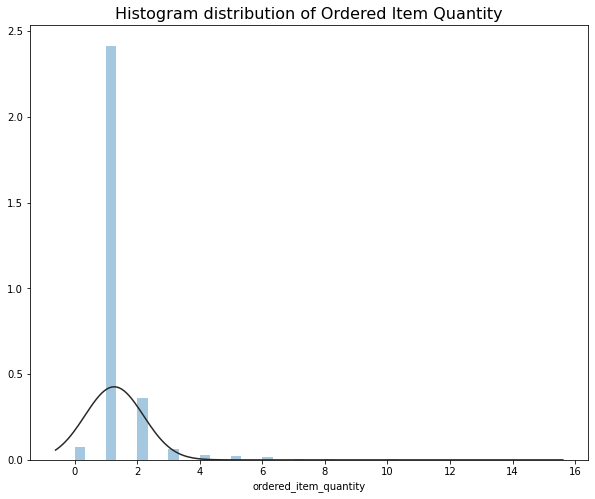

In [ ]:
# Plot ordered_item_quantity to see the distribution 
plt.rcParams["figure.figsize"] = [10,8]
sns.distplot(dfjh['ordered_item_quantity'], fit=stats.norm, kde=False)
sns.set_context("notebook", font_scale=1.5, rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 
plt.title('Histogram distribution of Ordered Item Quantity')
plt.show();

# Probability Plot

### Quantile-Quantile (Q-Q) Plot

This plot is to see the sample distribution relative to the normal distribution

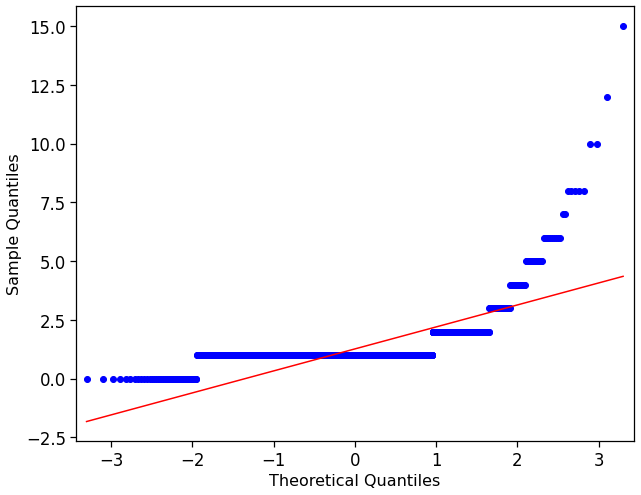

In [ ]:
# Quantile-Quantile (Q-Q) Plot
import statsmodels.api as sm

x = dfjh['ordered_item_quantity']

qq = sm.qqplot(x, line='s')
plt.show()

## Conclusion

### <span style='color:blue'> Above plot shows that the sample clearly doesn’t follow the normal distribution, therefore a non-parametric test will be preferred to test the hypothesis </span>

# Normality Tests

## D'Agostino-Pearson test

To further confirm the above conclusion, the following normality test is performed:

- D'Agostino-Pearson test

### Definition: D'Agostino-Pearson test
Calculates summary statistics from data, namely skewness and kurtosis. 
- Skew is a quantification of how much a distribution is pushed left or right, a measure of asymmetry in the distribution.
- Kurtosis quantifies how much of the distribution is in the tail. It is a simple and commonly used statistical test for normality.

It then calculates how far each of these values differs from the value expected with a Gaussian distribution in terms of asymmetry and shape, and computes a single P value from the sum of these discrepancies.

#### Hypothesis
- Test the hypothesis that the ordered item quantity do not follow a normal distribution
    - $H_0$: Sample follow a normal distribution 
    - $H_1$: Sample do not follow a normal *distribution*

In [ ]:
from scipy.stats import normaltest

(test_statistic, p_value) = normaltest(dfjh['ordered_item_quantity'])      

print("The test statistic is: ", round(test_statistic,3))
print("The p-value is: ", round(p_value,3),"\n")

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Sample likely not follow a normal distribution.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Sample likely follow a normal distribution.")

The test statistic is:  2328.551
The p-value is:  0.0 



NameError: ignored

#### Conclusion

Sample likely not follow a normal distribution

# Transformation

### Performed below transformation if normal distribution can be achieved

* Yeo Johnson Transformation
* Log Transformation

### Yeo-Johnson transformation
- No predetermined scale
- Exactly scale to zero mean and unit variance (i.e. standard deviation to 1)
- Make changes to distribution, therefore reduce skewness and kurtosis
- Less affected to outliers by maximum likelihood estimation
- Best on non-normal data with heteroscedasticity (unequal variability issue) and when normality are desired.

In [ ]:
# Define function for comparing two plots
def compare_plot(feature, transformed_feature):
    plt.rcParams["figure.figsize"] = 17,5
    fig,ax = plt.subplots(1,2)

    stdDev = np.round(np.std(feature)[0],4) # for normal distribution, standard deviation is 1
    skewness = np.round(skew(feature),4) # for normal distribution, skewness = 0
    excess_kurtosis = np.round(kurtosis(feature),4) # for normal distribution, excess kurtosis = 0
    sns.histplot(feature, kde=True, ax=ax[0], legend=False)
    ax[0].set_xlabel(feature.columns[0])
    ax[0].set_title("ORIGINAL \n Standard Dev.: {0} \n Skewness: {1} \n Kurtosis: {2}".format(stdDev, skewness, excess_kurtosis));

    transformed_stdDev = np.round(np.std(transformed_feature)[0],4)
    transformed_skewness = np.round(skew(transformed_feature),4)
    transformed_excess_kurtosis = np.round(kurtosis(transformed_feature),4)
    sns.histplot(transformed_feature, kde=True, ax=ax[1], legend=False)
    ax[1].set_xlabel(feature.columns[0])
    ax[1].set_title("TRANSFORMED \n Standard Dev.: {0} \n Skewness: {1} \n Kurtosis: {2}".format(transformed_stdDev, transformed_skewness, transformed_excess_kurtosis));

In [ ]:
from sklearn.preprocessing import PowerTransformer

# Select feature
feature = dfjh[["ordered_item_quantity"]]

# Transformation
pt = PowerTransformer() 
pt.fit(feature) 
transformed_feature = pt.transform(feature) 
transformed_feature = pd.DataFrame(transformed_feature)

# Plot
compare_plot(feature,transformed_feature)

In [ ]:
from scipy.stats import normaltest

(test_statistic, p_value) = normaltest(transformed_feature)      

print("The test statistic is: ", test_statistic)
print("The p-value is: ", p_value,"\n")

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Sample likely not follow a normal distribution.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Sample likely follow a normal distribution.")

### Log Transformation
- No predetermined scale
- Make changes to distribution, therefore reduce skewness and kurtosis
- Less affected by outliers due to using logarithm
- Best on non-normal data with outliers and when normality are desired. Only work on non-zero and positive data.

In [ ]:
from sklearn.preprocessing import FunctionTransformer

# Select feature
feature = dfjh[["ordered_item_quantity"]] # in series

# Transformation
transformer = FunctionTransformer(np.log1p, validate=True)
transformed_feature = transformer.transform(feature) # no fit and can perform transform directly on both training data and test data.
transformed_feature = pd.DataFrame(transformed_feature)

# Plot
compare_plot(feature,transformed_feature)

In [ ]:
from scipy.stats import normaltest

(test_statistic, p_value) = normaltest(transformed_feature)      

print("The test statistic is: ", test_statistic)
print("The p-value is: ", p_value,"\n")

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Sample likely not follow a normal distribution.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Sample likely follow a normal distribution.")

### <span style='color:blue'> Conclusion</span>

Sample data is not normally distributed hence non parametric testing

# Non Parametric Testing

## Wilcoxon Signed Rank Test

### 1) Hypothesis Testing
- Test the hypothesis on ordered item quantity that there is no difference between the sample median and the median of the product type with the highest transaction count
    - $H_0$: There is no difference between the sample median and the median of the product type with the highest transaction count
    - $H_1$: Sample median is greater than the median of the product type with the highest transaction count

In [ ]:
dfjh_1 = pd.DataFrame(dfjh.groupby("product_type").agg(mean_ordered_qty = ("ordered_item_quantity", "mean"), trx_count = ("ordered_item_quantity", "count")))
dfjh_1 = dfjh_1.sort_values(["trx_count"], ascending=False)
print("Each product type's mean value and transaction count")
print("====================================================")
print('')
print('Facial Mask has the highest transaction count')
display(dfjh_1.head(5))
print("="*120)
dfjh_2 = pd.DataFrame(dfjh_1.head(5))
print(dfjh_2['mean_ordered_qty'])
print("="*120)

In [ ]:
# By python function
#Specify the two variable that are believed to be paired
(test_statistic, p_value) = stats.wilcoxon(np.array((dfjh_2['mean_ordered_qty']))-(dfjh['ordered_item_quantity'].mean()), alternative='greater')

print("The test statistic is: ", round(test_statistic,5))
print("The p-value is: ", round(p_value,5), "\n")

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Samples are likely not having the same median.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Samples are likely having the same median")

##### Decision / Conclusion

Accept Null Hypothesis since p-value is greater than alpha.
Product types which have greater transaction count do not necessarily have more median ordered

### 2) Hypothesis Testing

#### Test the hypothesis that two or more product types

$\begin{align}
Null: & {{H}_{0}}:\, All\: {\mu}\: are\: equal \\ 
Alternative: & {{H}_{1}}:\, Not\: all\: {\mu}\: are\: equal \\ 
\end{align}$

In [ ]:
print(dfjh_1.head(5))

In [ ]:
# Get statistic of data of top 5 transaction counts

grp = dfjh.groupby("product_type")
print(grp["ordered_item_quantity"].describe())
print('='*120)

grpOne = dfjh.groupby("product_type").get_group("Facial Mask")
colA = grpOne["ordered_item_quantity"]

grpOne = dfjh.groupby("product_type").get_group("Weight Management")
colB = grpOne["ordered_item_quantity"]

grpOne = dfjh.groupby("product_type").get_group("Cleanser")
colC = grpOne["ordered_item_quantity"]

grpOne = dfjh.groupby("product_type").get_group("Daily & Health Supplements")
colD = grpOne["ordered_item_quantity"]

grpOne = dfjh.groupby("product_type").get_group("Essence")
colE = grpOne["ordered_item_quantity"]

In [ ]:
# By Python function

(test_statistic, p_value) = stats.f_oneway(colA, colB, colC, colD, colE)

print("The test statistic is: ", round(test_statistic,3))
print("The p-value is: ", round(p_value,3))

if p_value < alpha_value:
    print("At",alpha_value, "level of significance, we reject null hypothesis. Average order quantity for top 5 product types are not the same")
else:
    print("At",alpha_value, "level of significance, we failed to reject null hypothesis. Average order quantity for top 5 product types are the same")

##### Decision / Conclusion

We reject null hypothesis. Average order quantity for top 5 product types are not the same

# Another Non Parametric Testing

## 1) Wilcoxon Signed Rank Test

#### Test the hypothesis that sample distributions ordered quantity and returned quantity are equal
H0 : Sample distributions for order quantity and return quantity are equal.
H1 : Sample distributions for order quantity and return quantity are not equal.

In [ ]:
# Get statistic of data

colA = dfjh["ordered_item_quantity"]
print(colA.describe())
print("")

colB = dfjh["returned_item_quantity"]
print(colB.describe())

In [ ]:
# Specify the two variable that are believed to be paired
(test_statistic, p_value) = stats.wilcoxon(colB,colA, alternative='less')

print("The test statistic is: ", round(test_statistic,5))
print("The p-value is: ", round(p_value,5), "\n")

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Sample distributions for order quantity and return quantity are not equal.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Sample distributions for order quantity and return quantity are equal.")

## 2) Spearman-Correlations


### Test the hypothesis that there is monotonic association between product type and ordered quantity
- $H_0$: There is no monotonic association between product type and ordered quantity.
- $H_1$: There is monotonic association between product type and ordered quantity.

In [ ]:
from scipy.stats import spearmanr

(sprho, p_value) = spearmanr(jh_df_1['product_type'],jh_df_1['ordered_item_quantity'], nan_policy="omit")

print("The correlation coefficient is: ", '{:.2f}'.format(sprho))
print("The p-value is:",'{:.5f}'.format(p_value))

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Monotonic association likely exist between these two variables.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Monotonic association likely not exist between these two variables.")

### Test the hypothesis that there is monotonic association between ordered quantity and returned quantity
- $H_0$: There is no monotonic association between ordered quantity and returned quantity.
- $H_1$: There is monotonic association between ordered quantity and returned quantity.

In [ ]:
from scipy.stats import spearmanr

(sprho, p_value) = spearmanr(jh_df_1['ordered_item_quantity'],jh_df_1['returned_item_quantity'], nan_policy="omit")

print("The correlation coefficient is: ", '{:.2f}'.format(sprho))
print("The p-value is:",'{:.5f}'.format(p_value))

if p_value < alpha_value:
    print("At", alpha_value, "level of significance, we REJECT null hypothesis.")
    print("Conclusion: Monotonic association likely exist between these two variables.")
else:
    print("At", alpha_value, "level of significance, we FAILED TO REJECT null hypothesis.")
    print("Conclusion: Monotonic association likely not exist between these two variables.")

# Vincent's section

In [ ]:
if IS_RUNNING_GOOGLE_COLAB: 
    assert os.path.exists(zip_pathname), print(f"can't find {zip_pathname}")
    dfvc = get_df_from_protected_zipfile(zip_pathname = zip_pathname)
else:
    dfvc = pd.read_csv(csv_pathname)

dfvc.hour = pd.to_datetime(dfvc.hour)
print(f"type(dfvc.hour) ", type(dfvc.hour[0]))
 

In [ ]:
col_sum = ['product_price', 'orders', 'gross_sales', 'discounts', 'returns', 'net_sales',
           'shipping', 'taxes', 'total_sales', 'average_order_value', 'total_tips', 'total_cost',
           'gross_profit', 'gross_margin', 'units_per_transaction', 'customers', 'pending_sales',
           'net_quantity', 'ordered_item_quantity', 'average_units_ordered', 'returned_item_quantity',
           'percent_of_sales_with_staff_help']

## Plotting all orders

In [ ]:
dfvc=dfvc[dfvc.order_name.notnull()]
print(dfvc.shape)
df_sum = get_df_sum_by_date(
  dfvc,
  column_date="hour", 
  column_aggregate=col_sum, 
  freq='D',
  is_plot=True
  )

## 

In [ ]:
dfvc = dfvc[dfvc.financial_status=="paid"]
dfvc = dfcv[dfcv.sale_line_type=="product"]

print(dfvc.shape)

df_sum = get_df_sum_by_date(
  dfvc,
  column_date="hour", 
  column_aggregate=col_sum, 
  freq='D',
  is_plot=True
  )

df_sum["day_name"] = df_sum.hour.dt.day_name()
df_sum.rename(columns={"hour":"mmdd"},inplace=True)

cols = list(df_sum.columns)
display(df_sum[["mmdd", "day_name", "net_sales"]])


In [ ]:
## Dates analysis

# Data exploration using time series information
print(mydf.columns)
print(f"dataframe without considering order_name (shape {mydf.shape}) ")
display(mydf.head(2))
 
## Exclude rows without transactions

# Only keep rows that have transaction

mydf_notna = mydf[mydf.order_name.isna()==False]
print(f"dataframe with valid order_name (shape {mydf_notna.shape}) ")
display(mydf_notna.head(2))
print(f"only keep rows with non-zero order_name")
df = mydf_notna
#'total_sales', 'gross_sales', 'average_order_value', 'returned_item_quantity', 
#'gross_profit', 'ordered_item_quantity', 'net_quantity', 'product_type'

In [ ]:
mydf.reset_index(inplace=True)
mydf["HH"] = mydf.hour.dt.hour     
mydf.set_index("hour", inplace=True)
display(mydf[["HH", "gross_sales"]].head(2))   

# Soon Chee's section

In [ ]:
dfsc = pd.read_csv(data_dir + "Ecommerce - Hour Data.csv")

# Terry's section

In [ ]:
dftz = pd.read_csv(data_dir + "Ecommerce - Hour Data.csv")

# John's section

In [ ]:
dfjw = pd.read_csv(data_dir + "Ecommerce - Hour Data.csv")

# Common section to check errors


In [ ]:
os.remove(csv_pathname)
print(f"removed {csv_pathname}")    

In [ ]:
# catch error message
!grep -rni "error" "./Team 5 Project (JH) v1.0.ipynb"

In [ ]:
print(f"END time {str(dt.datetime.now(pytz.timezone('Singapore'))).split('.')[0]}")